In [31]:
import phoebe
import pickle
import json
import os
import sys
from glob import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [7]:
import requests
import os
from urllib.parse import urljoin

# URL of the GitHub directory containing the .pb3 files
base_url = "https://github.com/phoebe-project/phoebe2-tables/tree/master/passbands"

# Create a directory to store the downloaded files
os.makedirs("phoebe_passbands", exist_ok=True)

# Function to get raw content URL from GitHub URL
def get_raw_url(url):
    return url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

# Send a GET request to the GitHub page
response = requests.get(base_url)

# Parse the HTML content to find all .pb3 file links
from bs4 import BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')
pb3_links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith('.pb3')]

# Download each .pb3 file
for link in pb3_links:
    file_url = get_raw_url(urljoin("https://github.com", link))
    file_name = os.path.join("phoebe_passbands", os.path.basename(link))
    
    print(f"Downloading {file_name}...")
    file_response = requests.get(file_url)
    
    with open(file_name, 'wb') as file:
        file.write(file_response.content)

print("All .pb3 files have been downloaded to the 'phoebe_passbands' directory.")


All .pb3 files have been downloaded to the 'phoebe_passbands' directory.


In [77]:
def load_phoebe_passband(fname: str):
    with open(fname, 'rb') as f:
        struct = pickle.load(f)
        return struct
    
def get_transmission_curve(phoebe_passband):
    return phoebe_passband['ptf_func'][0]*1e11, phoebe_passband['ptf_func'][1]

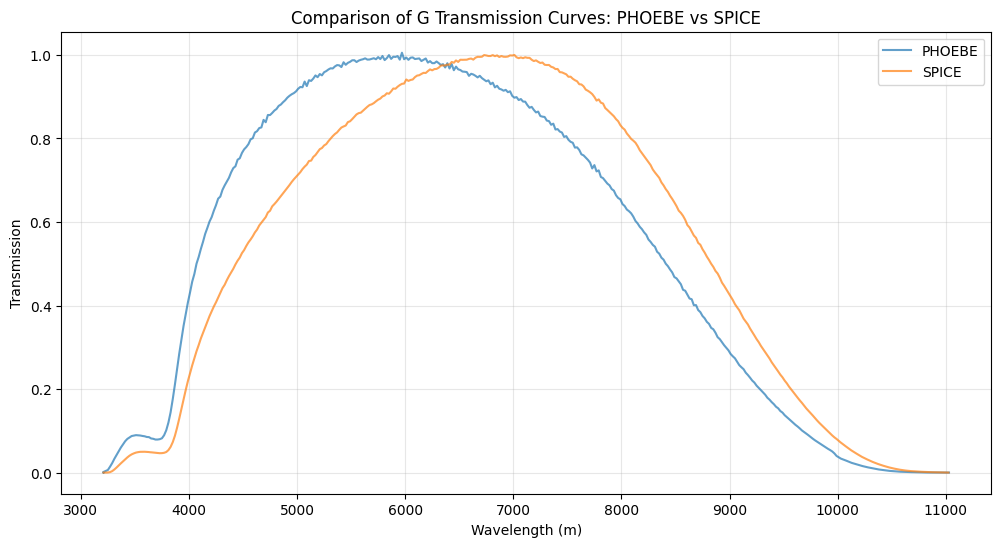

PHOEBE G wavelength range: 3.21e+03 - 1.10e+04 m
SPICE G wavelength range: 3210.00 - 11025.00 Å
PHOEBE G number of points: 366
SPICE G number of points: 362
Root Mean Square Error between curves: 0.138490
Passband name: Gaia:G
Number of points in the transmission curve: 366
Wavelength range: 3.21e+03 - 1.10e+04 m


In [78]:
import numpy as np
import matplotlib.pyplot as plt

from spice.spectrum.filter import GaiaG
import jax.numpy as jnp

def compare_phoebe_spice_passbands(phoebe_passband, spice_filter):
    # Load and process the PHOEBE passband data
    wavelengths, transmission = get_transmission_curve(phoebe_passband)
    wavelengths = wavelengths * 1e-1  # Convert to meters

    # Load the SPICE filter
    spice_wavelengths = spice_filter.transmission_curve_wavelengths[0]
    spice_transmission = spice_filter.transmission_curve_wavelengths[1]

    # Interpolate PHOEBE's transmission curve to match SPICE's wavelengths
    phoebe_transmission_interp = jnp.interp(spice_wavelengths, wavelengths, transmission)

    # Plot comparison of transmission curves
    plt.figure(figsize=(12, 6))
    plt.plot(wavelengths, transmission, label='PHOEBE', alpha=0.7)
    plt.plot(spice_wavelengths, spice_transmission, label='SPICE', alpha=0.7)
    plt.title(f'Comparison of {phoebe_passband["pbname"]} Transmission Curves: PHOEBE vs SPICE')
    plt.xlabel('Wavelength (m)')
    plt.ylabel('Transmission')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Compare wavelength ranges
    print(f"PHOEBE {phoebe_passband['pbname']} wavelength range: {wavelengths.min():.2e} - {wavelengths.max():.2e} m")
    print(f"SPICE {phoebe_passband['pbname']} wavelength range: {spice_wavelengths.min():.2f} - {spice_wavelengths.max():.2f} Å")

    # Compare number of data points
    print(f"PHOEBE {phoebe_passband['pbname']} number of points: {len(wavelengths)}")
    print(f"SPICE {phoebe_passband['pbname']} number of points: {len(spice_wavelengths)}")

    # Calculate and print RMSE between the two curves
    common_mask = (spice_wavelengths >= wavelengths.min()) & (spice_wavelengths <= wavelengths.max())
    rmse = jnp.sqrt(jnp.mean((spice_transmission[common_mask] - phoebe_transmission_interp[common_mask])**2))
    print(f"Root Mean Square Error between curves: {rmse:.6f}")

    # Print passband information
    print(f"Passband name: {phoebe_passband['pbset']}:{phoebe_passband['pbname']}")
    print(f"Number of points in the transmission curve: {len(wavelengths)}")
    print(f"Wavelength range: {wavelengths.min():.2e} - {wavelengths.max():.2e} m")

# Example usage:
gaia_g_passband = t
spice_gaia_g = GaiaG()
compare_phoebe_spice_passbands(gaia_g_passband, spice_gaia_g)


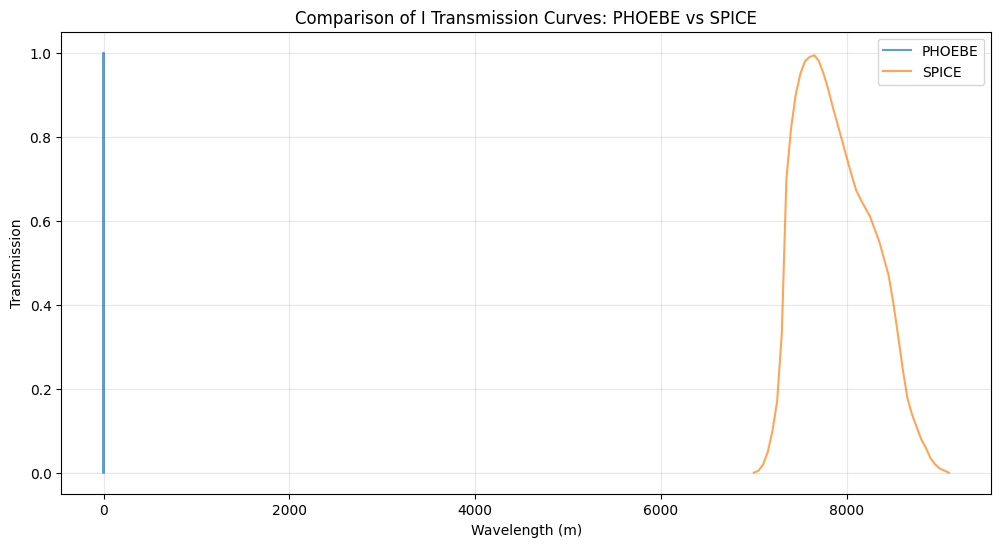

PHOEBE I wavelength range: 7.00e-08 - 8.90e-08 m
SPICE I wavelength range: 7000.00 - 9100.00 Å
PHOEBE I number of points: 9505
SPICE I number of points: 43
Root Mean Square Error between curves: nan
Passband name: Cousins:I
Number of points in the transmission curve: 9505
Wavelength range: 7.00e-08 - 8.90e-08 m


In [74]:
from spice.spectrum.filter import CousinsI

spice_gaia_g = GaiaG()
compare_phoebe_spice_passbands(load_phoebe_passband('phoebe_passbands/cousins_i.pb3'), CousinsI())

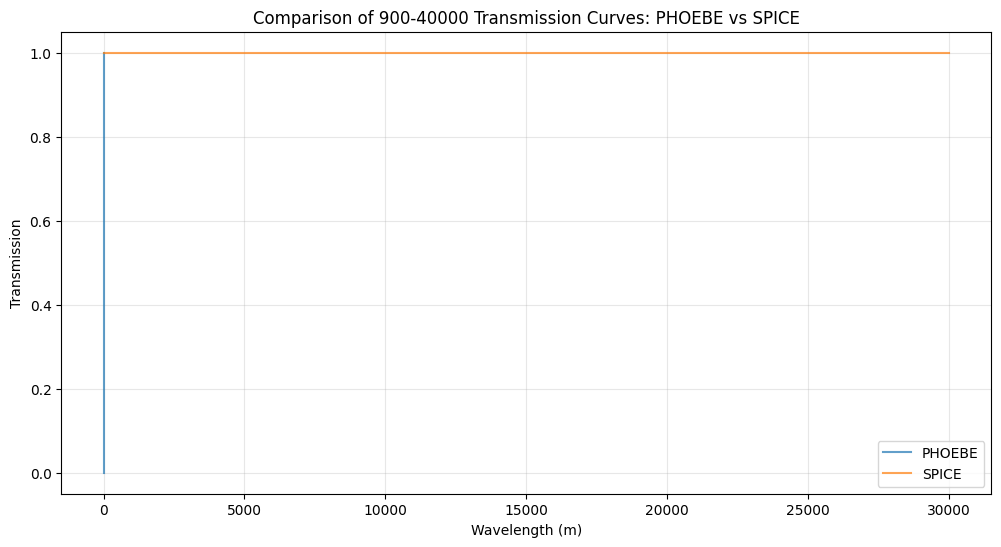

PHOEBE 900-40000 wavelength range: 9.00e-09 - 4.00e-07 m
SPICE 900-40000 wavelength range: 1.00 - 30000.00 Å
PHOEBE 900-40000 number of points: 396
SPICE 900-40000 number of points: 2
Root Mean Square Error between curves: nan
Passband name: Bolometric:900-40000
Number of points in the transmission curve: 396
Wavelength range: 9.00e-09 - 4.00e-07 m


In [69]:

from spice.spectrum.filter import Bolometric

compare_phoebe_spice_passbands(load_phoebe_passband('phoebe_passbands/bolometric.pb3'), Bolometric())

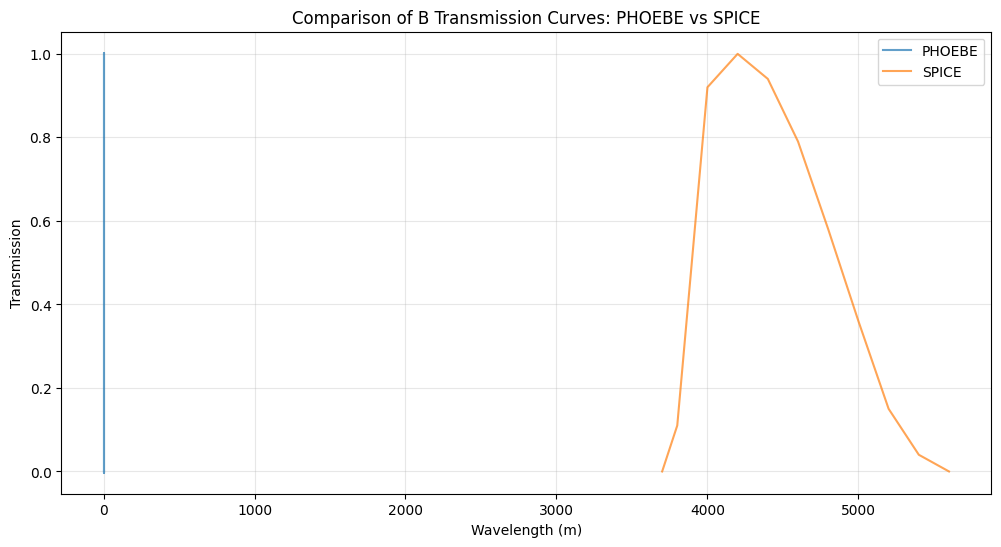

PHOEBE B wavelength range: 3.60e-08 - 5.55e-08 m
SPICE B wavelength range: 3700.00 - 5600.00 Å
PHOEBE B number of points: 44
SPICE B number of points: 11
Root Mean Square Error between curves: nan
Passband name: Johnson:B
Number of points in the transmission curve: 44
Wavelength range: 3.60e-08 - 5.55e-08 m


In [70]:
from spice.spectrum.filter import JohnsonB


compare_phoebe_spice_passbands(load_phoebe_passband('phoebe_passbands/johnson_b.pb3'), JohnsonB())

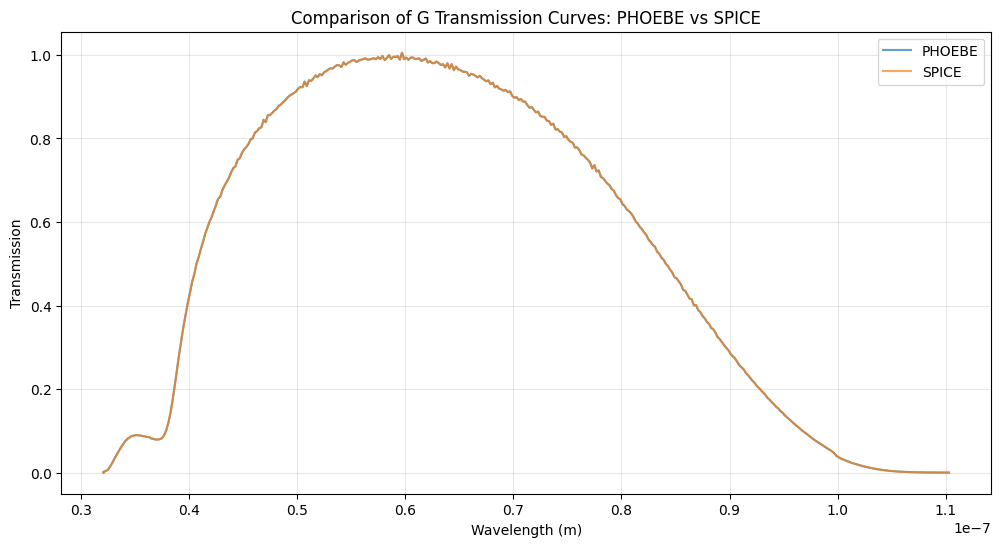

PHOEBE G wavelength range: 3.21e-08 - 1.10e-07 m
SPICE G wavelength range: 0.00 - 0.00 Å
PHOEBE G number of points: 366
SPICE G number of points: 366
Root Mean Square Error between curves: 0.000145
Passband name: Gaia:G
Number of points in the transmission curve: 366
Wavelength range: 3.21e-08 - 1.10e-07 m


In [71]:
from spice.spectrum.filter import Filter
import numpy as np

def create_phoebe_filter(phoebe_passband):
    # Extract wavelengths and transmission values from PHOEBE passband
    wavelengths, transmission = get_transmission_curve(phoebe_passband)
    wavelengths = wavelengths * 1e-1
    
    # Create transmission curve as a 2D array
    transmission_curve = np.array([wavelengths, transmission])
    
    # Create a Filter object
    filter_name = f"{phoebe_passband['pbset']}:{phoebe_passband['pbname']}"
    phoebe_filter = Filter(transmission_curve, name=filter_name)
    
    return phoebe_filter

# Example usage:
johnson_b_passband = load_phoebe_passband('phoebe_passbands/gaia_g.pb3')
phoebe_johnson_b_filter = create_phoebe_filter(johnson_b_passband)

# Compare PHOEBE filter with SPICE filter
compare_phoebe_spice_passbands(johnson_b_passband, phoebe_johnson_b_filter)

# You can now use this function to create filters for any PHOEBE passband
